# Import Packages

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from gensim.corpora import Dictionary
from gensim.models import Word2Vec

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import BinaryAccuracy, Recall, AUC
tf.get_logger().setLevel('ERROR')

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

### Load in Pickeled DataFrame

In [2]:
tweets = pd.read_pickle('data/pickle_jar/cleaned2.pkl')
denier_sup = pd.read_pickle('data/pickle_jar/denier_sup.pkl')

## Explore Data

In [3]:
# verify import
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1970258 entries, 0 to 1970257
Data columns (total 21 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   created_at               datetime64[ns]
 1   id                       int64         
 2   full_text                object        
 3   truncated                bool          
 4   in_reply_to_screen_name  object        
 5   is_quote_status          bool          
 6   retweet_count            int64         
 7   favorite_count           int64         
 8   lang                     object        
 9   retweeted_status         object        
 10  names                    object        
 11  screen_names             object        
 12  locations                object        
 13  follower_counts          int64         
 14  user_created_at          object        
 15  verified                 bool          
 16  statuses_counts          int64         
 17  location                 ob

In [4]:
# look at missing values
tweets.isna().sum()

created_at                       0
id                               0
full_text                        0
truncated                        0
in_reply_to_screen_name    1525932
is_quote_status                  0
retweet_count                    0
favorite_count                   0
lang                             0
retweeted_status           1970258
names                            0
screen_names                     0
locations                        0
follower_counts                  0
user_created_at                  0
verified                         0
statuses_counts                  0
location                   1889581
country                    1889581
hashtags                   1234431
withheld_in_countries      1970213
dtype: int64

In [5]:
denier_sup['date'] = pd.to_datetime(denier_sup['date'])
denier_sup.columns = ['created_at', 'screen_names', 'names', 'full_text', 'retweeted_status', 
                      'hashtags', 'nlikes', 'search']

## Prepare Data for Modeling

First, ground truth must be determined. To do this, hashtags are examined and parsed to find ones that clearly indicate a person's view on climate change. Then all tweets containing those tweets are labeled and prepared for modeling

In [6]:
# subset data that contains hashtags
df = tweets.dropna(subset=['hashtags'])

In [7]:
# create a list of all hashtags

hashtags_all = []
for row in df['hashtags']:
    for item in row:
        hashtags_all.append(item.lower())

In [8]:
# see hashtag count and sort by frequency
unique_hashtags = list(pd.Series(hashtags_all).value_counts().index)
# view top 5 for reference
print(unique_hashtags[:5])

['climatechange', 'globalwarming', 'climateaction', 'environment', 'climate']


After spending some time sifting through the tweets and their hashtags, these are some of the most common and most defininitively classifying hastags: 

In [9]:
# most common tags associated with sample of tweets presenting climate denial
denier_tags = ['climatechangeisfalse', 'climatechangenotreal', 'climatechangehoax', 
               'globalwarminghoax', 'tcot', 'ccot', 'tlot', 'pjnet', 'rednationrising', 'votered', 
               'libtard', 'libtards', 'maga']

# most common tags associated with sample of tweets indicating belief in climate science
believer_tags = ['climatechangeisreal', 'actonclimate', 'extinctionrebellion', 'climateemergency', 
                 'climateactionnow', 'capitalism', 'public_health', 'climateaction', 'humanityextinction',
                 'activism', 'noplanetb', 'savetheplanet']

Loop through the datset and look for matching hashtags to the believer and denier hashtag set then create a list to be appended to the dataframe containing the order of believer positive and believer negative cases.

In [10]:
# assign believer status to each row in the dataset
believe_series = []
for idx, row in df['hashtags'].iteritems():
    # set a count for matching tags in row
    believe = 0
    deny = 0 
    for tag in row:
        if tag.lower() in denier_tags:
            deny += 1
        elif tag.lower() in believer_tags:
            believe += 1
    
    # check that only one type of tag appears
    if (believe > 0) and (deny == 0):
        believe_series.append(1)
    elif (believe == 0) and (deny > 0):
        believe_series.append(0)
    else: # <-- if no matching tag OR if both appear, label as unknown using nonetype 
        believe_series.append(None)

### Add believer status to DataFrame

In [11]:
# create column in dataframe for the believer_series
df = df.assign(believer = believe_series)

In [12]:
# create column in dataframe for the supplemental denier data
denier_sup['believer'] = 0

In [13]:
# subset dataframe to only include positive and negative cases
to_train = df.dropna(subset=['believer'])

### Create function to prep text for NLP processing

Remove emojis, unwanted character types, hashtags, usernames, and URLs. Remove line breaks and extra spaces

Then create function to lemmatize then rejoin text, a function to combine cleaning and lemmatizing, and a function to perform a quality check

In [14]:
def re_clean(tweet):
    '''
    takes the text of a tweet and returns a cleaned string ready for tokenization and lemmatization 
    '''
    # remove emojis
    emoji = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    tweet = emoji.sub('', tweet)
    # regex cleaning
    tweet = tweet.lower()
    tweet = re.sub(r'[@][\w]+','', tweet) # <-- remove usernames
    tweet = re.sub(r'[#]','', tweet) # <-- remove hashtags 
    tweet = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet) # <-- remove urls
    tweet = re.sub(r'(?:^| )\w(?:$| )', ' ', tweet) # <-- remove one letter words
    tweet = re.sub(r'\s{2,15}', ' ', tweet) # <-- remove extra blank spaces
    tweet = re.sub(r'\n', ' ', tweet)  # <-- remove line breaks
    tweet = re.sub(r'\s{2,15}', ' ', tweet) # <-- combine multiple space again 
    return tweet.strip() # <-- remove lingering spaces at the start and end of tweets

In [15]:
# Instantiate nltk lemmatizer
lemmatizer = WordNetLemmatizer()

# create stop word list from default list, punctuation, and hashtags used to create classifcation params
stopwords_list = stopwords.words('english') + (list(string.punctuation) + 
                                               denier_tags + believer_tags + unique_hashtags[:100])
def lemm(tweet):
    '''
    lemmatizes a sentence and returns string ready to be vectorized
    '''
    # tokenize, lemmatize
    tok = nltk.regexp_tokenize(tweet, r"([a-zA-Z]+(?:'[a-z]+)?)")
    lemma = [lemmatizer.lemmatize(token) for token in tok]
    # return combined string 
    return ' '.join(lemma)

In [16]:
def clean_and_lem(tweet):
    '''
    clean then lammatize tweet
    '''
    return lemm(re_clean(tweet))

def tok(tweet):
    return nltk.regexp_tokenize(tweet, r"([a-zA-Z]+(?:'[a-z]+)?)")

In [17]:
# create function to compare original text to cleaned text 
def check_cleaned(df, n = None):
    '''
    sanity check function. Look at cleaned text for edge case detection.
    '''
    if not n:
        n = np.random.randint(0, len(df) - 1)
    print(f"ORIGINAL: \n{df.iloc[n]['full_text']} \n")
    print(f"CLEANED: \n{clean_and_lem(df.iloc[n]['full_text'])}")
    
check_cleaned(to_train)

ORIGINAL: 
Why Climate Change Increases The Risk Of Violent Conflicts: 
https://t.co/axNsqeUi99
#climatechange #climateaction 
#environment 
#energy https://t.co/WFPWwjNVZ5 

CLEANED: 
why climate change increase the risk of violent conflict climatechange climateaction environment energy


###### Prepare Dataset for modeling

Combine dataset with supplemental denial data, reset the index, and drop extra index column, then clean and lemmatize

In [81]:
X = to_train['full_text'].combine_first(denier_sup['full_text']).reset_index()
X = X.drop(columns='index')['full_text']
X = X.map(clean_and_lem)

In [82]:
# create target variable on combined dataset and supplemental denial data
y = to_train['believer'].combine_first(denier_sup['believer'])
y = y.reset_index().drop(columns='index')['believer']

## TF-IDF Vectorizer Modeling

In [89]:
# train test split with stratification to account for class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

vectorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=(1,2), max_df = 0.9)

X_tfidf_train = vectorizer.fit_transform(X_train)
X_tfidf_test = vectorizer.transform(X_test)

In [101]:
pickle_sandwich = (X_tfidf_train, X_tfidf_test, y, y_train, y_test)
pickle_out = open('data/pickle_jar/X_tfidf.pkl', 'wb')
pickle.dump(pickle_sandwich, pickle_out)
pickle_out.close()

In [98]:
# pickle_in = open('data/pickle_jar/X_tfidf.pkl', 'rb')
# X_tfidf_train, X_tfidf_test, y, y_train, y_test = pickle.load(pickle_in)
# pickle_in.close()

In [84]:
# create dictionary holding class imbalnce
class_weights = dict(y.value_counts(normalize=True))

In [88]:
# create grid search parameters
rfc_grid_params =  {'n_estimators': [100, 450, 800],
                    'criterion': ['gini', 'entropy'],
                    'max_depth': [None, 6, 10],
                    'class_weight': [class_weights]}

lr1_grid_params = {'C': [1, 1e3, 1e7, 1e12],
                   'penalty': ['l1', 'elasticnet'],
                   'solver': ['saga'],
                   'class_weight': [class_weights]}

lr2_grid_params = {'C': [1, 1e3, 1e7, 1e12],
                   'penalty': ['l2', 'none'],
                   'solver': ['sag'],
                   'class_weight': [class_weights]}

gbt_grid_params = {'learning_rate': [0.001, 0.1, 1]}

In [ ]:
# Instantiate gridsearch object 
lr1_grid = GridSearchCV(LogisticRegression(random_state=42), param_grid=lr1_grid_params, cv=3 n_jobs = -1)
# fit to training set
lr1_grid.fit(X_tfidf_train, y_train)

pickle_out = open('data/pickle_jar/lr1_grid', 'wb')
pickle.dump(lr1_grid, pickle_out)
pickle_out.close()

In [ ]:
# Instantiate gridsearch object 
lr2_grid = GridSearchCV(LogisticRegression(random_state=42), param_grid=lr2_grid_params, cv=3 n_jobs = -1)
# fit to training set
lr2_grid.fit(X_tfidf_train, y_train)

pickle_out = open('data/pickle_jar/lr2_grid', 'wb')
pickle.dump(lr2_grid, pickle_out)
pickle_out.close()

In [ ]:
# Instantiate gridsearch object 
gbt_grid = GridSearchCV(HistGradientBoostingClassifier(random_state=42), param_grid=gbt_grid_params, cv=3 n_jobs = -1)
# fit to training set
gbt_grid.fit(X_tfidf_train, y_train)

pickle_out = open('data/pickle_jar/gbt_grid', 'wb')
pickle.dump(gbt_grid, pickle_out)
pickle_out.close()

In [32]:
# Instantiate gridsearch object 
rfc_grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=rfc_grid_params, cv=3 n_jobs = -1)
# fit to training set
rfc_grid.fit(X_tfidf_train, y_train)

pickle_out = open('data/pickle_jar/rfc_grid', 'wb')
pickle.dump(rfc_grid, pickle_out)
pickle_out.close()

GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                    

In [34]:
rf_gridsearch.best_params_

{'clf__n_estimators': 100}

In [35]:
# show pipeline accuracy score for best parameters
rf_gridsearch.score(X_test, y_test)

0.9127894908519408

In [36]:
# generate predictions 
y_pred_train = rf_gridsearch.predict(X_train)
y_pred = rf_gridsearch.predict(X_test)

In [37]:
# compare F1 and Accuracy scores to check for overfitting 
print(f'Train Accuracy: {round(accuracy_score(y_train, y_pred_train), 4)}')
print(f'Train F1 Score: {round(f1_score(y_train, y_pred_train), 4)}')
print('-----'*6)
print(f'Test Accuracy:  {round(accuracy_score(y_test, y_pred), 4)}')
print(f'Test F1 Score:  {round(f1_score(y_test, y_pred), 4)}')

Train Accuracy: 0.9692
Train F1 Score: 0.981
------------------------------
Test Accuracy:  0.9128
Test F1 Score:  0.9472


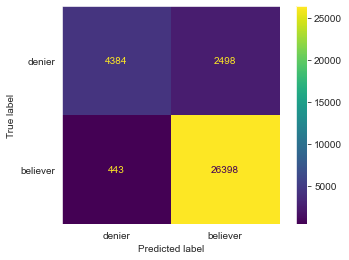

In [47]:
# visualize confusion matrix for test data
con_mat = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(con_mat, display_labels=['denier', 'believer']).plot()
plt.grid(b=None)
plt.show()

#### Logreg Gridsearch

In [ ]:
# Instantiate gridsearch object 
lr_gridsearch = GridSearchCV(lr_pipeline, param_grid=lr_grid_par, cv=3, n_jobs = -1)
# fit to training set
lr_gridsearch.fit(X_train, y_train)

In [ ]:
lr_gridsearch.best_params_

In [ ]:
# show pipeline accuracy score for best parameters
lr_gridsearch.score(X_test, y_test)

In [ ]:
# generate predictions 
y_pred_train2 = lr_gridsearch.predict(X_train)
y_pred2 = lr_gridsearch.predict(X_test)

In [ ]:
# compare F1 and Accuracy scores to check for overfitting 
print(f'Train Accuracy: {round(accuracy_score(y_train, y_pred_train2), 4)}')
print(f'Train F1 Score: {round(f1_score(y_train, y_pred_train2), 4)}')
print('-----'*6)
print(f'Test Accuracy:  {round(accuracy_score(y_test, y_pred2), 4)}')
print(f'Test F1 Score:  {round(f1_score(y_test, y_pred2), 4)}')

In [ ]:
# visualize confusion matrix for test data
con_mat = confusion_matrix(y_test, y_pred2)
display = ConfusionMatrixDisplay(con_mat, display_labels=['denier', 'believer']).plot()


# Test on external dataset

A dataset from kaggle with labeled tweets as climate deniers or believers is imported for further validation of model

https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset

In [25]:
val_df = pd.read_csv('data/twitter_sentiment_data.csv')

In [26]:
# re-map sentiment array to match existing model

cond_list = [val_df['sentiment'] == -1, 
             val_df['sentiment'] == 0,
             val_df['sentiment'] == 1,
             val_df['sentiment'] == 2]

choice_list = [0, None, val_df['sentiment'], None]

val_df['sentiment'] = np.select(cond_list, choice_list, 10)

In [27]:
# check for errors
val_df['sentiment'].value_counts()

1    22962
0     3990
Name: sentiment, dtype: int64

In [28]:
# check for matching tweets across datasets
count = 0
for id_ in val_df['tweetid']:
    if id_ in tweets['id']:
        count += 1
        print(id_)

In [29]:
# remove rows without usable ground truth
val_df_sub = val_df.dropna(subset = ['sentiment'])

# remove retweets
val_df_sub = val_df_sub[~val_df_sub['message'].str.startswith('RT ')]

In [30]:
# clean tweets
val_processed_text = val_df_sub['message'].apply(lambda x: clean_and_lem(x))

In [31]:
# make predictions on validation data
val_predict = rf_gridsearch.predict(val_processed_text)
y = val_df_sub['sentiment'].astype(int)

Accuracy Score :      0.8241
Validation F1 Score : 0.8939


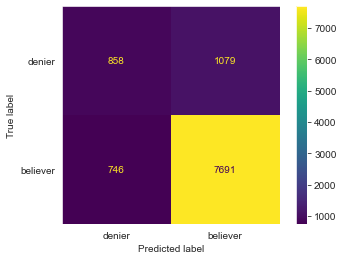

In [32]:
print(f"Accuracy Score :      {round(accuracy_score(y, val_predict), 4)}")
print(f"Validation F1 Score : {round(f1_score(y, val_predict), 4)}")

ConfusionMatrixDisplay(confusion_matrix(y, val_predict), display_labels=['denier', 'believer']).plot()
plt.grid(b=None)
plt.show()

## Apply Classifier to remainder dataset

Run the entire dataset through the gridsearch pipeline to make predictions on each tweet

In [33]:
# remove irrelevant response tweets
tweets_final = tweets[tweets['in_reply_to_screen_name'].isna()]

In [34]:
# prepare tweets for model
tweets_final['clean_text'] = tweets_final['full_text'].apply(lambda x: clean_and_lem(x)) 
tweets_final = tweets_final[tweets_final.clean_text.str.strip() != '']
tweets_final = tweets_final[tweets_final.clean_text.str.strip() != ' ']
# run text through model
tweets_final['believer_pred'] = rf_gridsearch.predict(tweets_final['clean_text'])

/Users/browz/opt/anaconda3/envs/ds01/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
tweets_final['believer_pred'].value_counts(normalize=True)

1.0    0.931688
0.0    0.068312
Name: believer_pred, dtype: float64

In [36]:
# sanity check on predictions
def check_pred(df, n=None):
    if n == None:
        n = np.random.randint(0,len(df)-1)
    print(df.iloc[n]['full_text'], '\n', df.iloc[n]['believer_pred'])
    print(f'https://twitter.com/{df.iloc[n]["screen_names"]}/status/{df.iloc[n]["id"]}')

In [37]:
check_pred(tweets_final[tweets_final['believer_pred']==0])

Ayo Mueller man, where are you? These Hollywood niggas got you looking funny in the light. Pull up! https://t.co/6SrmAvjZbG 
 0.0
https://twitter.com/Lady_RHOalye/status/1026982347487498245


# Sentiment Analysis

In [38]:
def sentiment_score(sentence): 
  
    # Instntiate SentimentIntensityAnalyzer object
    sid_obj = SentimentIntensityAnalyzer() 
  
    # store scoring data in dictionary  
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    
    return sentiment_dict['compound']

In [39]:
sentiment = to_train['full_text'].apply(lambda x: sentiment_score(x))

In [40]:
to_train = to_train.assign(sent = sentiment)

In [41]:
to_train.groupby(['believer'])['sent'].mean()

believer
0.0   -0.023605
1.0    0.060709
Name: sent, dtype: float64

In [42]:
sent_df = to_train[to_train['sent'] != 0].copy()
sent_df['sent'] = sent_df['sent'].multiply(100)

In [43]:
conditions = [sent_df['sent'].isin(range(-100,-50)),
              sent_df['sent'].isin(range(-50, 0)),
              sent_df['sent'].isin(range(0, 50)),
              sent_df['sent'].isin(range(50, 100))]

choices =[-2,-1,0,1]

sent_df['sent_cat'] = np.select(condlist=conditions, choicelist=choices)

In [44]:
sent_df['sent_cat'].value_counts()

 0    70797
-1     1418
 1      182
-2       92
Name: sent_cat, dtype: int64

In [45]:
3

3

/Users/browz/opt/anaconda3/envs/ds01/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


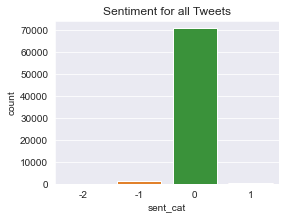

In [50]:
plt.figure(figsize=(4,3))
sns.countplot(sent_df['sent_cat'])
plt.title('Sentiment for all Tweets')
plt.show()

In [75]:
grouped_believe = sent_df.groupby(['sent_cat','believer'])['created_at'].count()
grouped_believe
# plt.figure(figsize=(4,3))
# sns.bar(grouped_sent)
# plt.title('Class distribution for Each Sentiment Category')

sent_cat  believer
-2        0.0             8
          1.0            84
-1        0.0            95
          1.0          1323
 0        0.0          3338
          1.0         67459
 1        0.0             3
          1.0           179
Name: created_at, dtype: int64

In [62]:
pickle_out = open('data/model.pkl', 'wb')
pickle.dump(rf_gridsearch, pickle_out)
pickle_out.close()

In [22]:
pickle_in = open('data/model.pkl', 'rb')
rf_gridsearch = pickle.load(pickle_in)

In [23]:
pickle_in.close()